In [1]:
import graphviz
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score

import shap

/home/users/jcd97/code/rashomon-submodels/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### For a simple dataset where the DGP is just X1 & X2, we show that two equiv expressions of the DGP have different purity based VI

In [2]:
# build data
N = 100
M = 2
X = np.zeros((N, M))
X.shape
y = np.zeros(N)
X[: N // 2, 0] = 1
X[: N // 4, 1] = 1
X[N // 2 : 3 * N // 4, 1] = 1
X[:, 2:] = np.random.randint(0, 1, size=(X.shape[0], M - 2))
y[: 1 * N // 4] = 1

In [3]:
# fit model
and_model = DecisionTreeClassifier(max_depth=2, random_state=0)
and_model.fit(X, y)

# draw model
dot_data = export_graphviz(and_model,feature_names=["X1", "X2"], out_file=None, filled=False, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("./dupe_tree_1", format="svg")

'dupe_tree_1.svg'

In [4]:
# fit model
and_model_2 = DecisionTreeClassifier(max_depth=2, random_state=2)
and_model_2.fit(X, y)

# draw model
dot_data = export_graphviz(and_model_2, feature_names=["X1", "X2"], out_file=None, filled=False, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)

graph.render("./dupe_tree_2", format="svg")

'dupe_tree_2.svg'

In [5]:
and_model.feature_importances_, and_model_2.feature_importances_

(array([0.66666667, 0.33333333]), array([0.33333333, 0.66666667]))

### Now, we show that as the number of anded variables increase, VI becomes arbitrarily unstable

In [6]:
def binary_counting_matrix(m):
    """
    Creates a binary counting matrix with m binary variables.

    Parameters:
        m (int): Number of binary variables.

    Returns:
        np.ndarray: A matrix of shape (2^m, m) representing binary counting.
    """
    # Number of rows is 2^m
    rows = 2 ** m
    # Use binary representation and format to create the matrix
    return np.array([[int(x) for x in format(i, f'0{m}b')] for i in range(rows)])


In [7]:
# build data
M = 10 # The number of anded variables
M_dummy = 2 # The number of useless variables
X = binary_counting_matrix(M + M_dummy)
y = np.prod(X[:, :M], axis=1)

vi_list = []
for rs in range(3):
  # fit model
  model = DecisionTreeClassifier(max_depth=M + M_dummy, random_state=rs)
  model.fit(X, y)
  assert accuracy_score(y, model.predict(X)) == 1
  vi_list.append(model.feature_importances_)

all_vis = np.stack(vi_list, axis=0)

/tmp/ipykernel_2081824/3030758611.py:16: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  g = sns.pointplot(


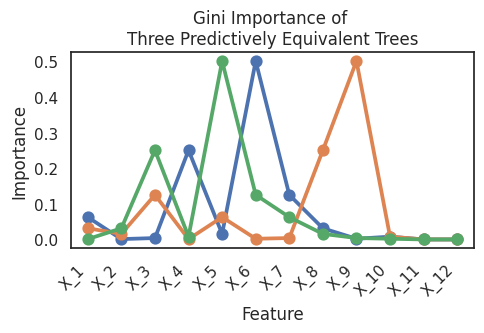

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(5,3.5))
sns.set(font_scale=1.5)
importance_df = pd.DataFrame({
    "Feature": np.repeat(np.array([f"X_{i+1}" for i in range(M)] + [f"X_{i+11}" for i in range(M_dummy)]), all_vis.shape[0]),
    "Tree": np.concatenate([np.arange(all_vis.shape[0]) for i in range(all_vis.shape[1])]),
    "Importance": np.concatenate([all_vis[:, i] for i in range(all_vis.shape[1])]),
    "Used in DGP": np.repeat(np.array([True for i in range(M)] + [False for i in range(M_dummy)]), all_vis.shape[0])
})
# sns.set_theme('paper')
# sns.set_palette('colorblind')
sns.set_theme(style='white')
g = sns.pointplot(
    data=importance_df, 
    x='Feature', 
    y='Importance', 
    hue="Tree", 
    palette=sns.color_palette())#, color=".25", alpha=0.7)
g.legend_.remove()
plt.title("Gini Importance of \nThree Predictively Equivalent Trees")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("larger_vi.pdf")